# Projeto C318

O projeto tem como intuito fazer uma anásile de um dataset fornecido neste link do [Kaggle](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?resource=download&select=diabetes.csv).  
No qual, se trata de um dataset que contém alguns dados médicos, em particular, de mulheres com pelo menos 21 anos e de ascendência indígena Pima.  
Cujo o intuito é criar um modelo de ML, capaz de prever se o paciente tem ou não diabetes.

## Importação de Bibliotecas

In [239]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit

## Análise dos dados

In [195]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [196]:
print(f"Este dataset contém os dados clínicos de {len(df)} pacientes")
print(f"Features: {df.columns.to_list()[:-1]}")
print(f"Target: {df.columns.to_list()[-1]}")
print(f"Existe valores faltantes? {df.isna().any().any()}")

Este dataset contém os dados clínicos de 768 pacientes
Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Target: Outcome
Existe valores faltantes? False


Diante dos tipos de dados apresentados, pode-se concluir que o dataset escolhido não apresenta variáveis categóricas

In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [198]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Análise da Variável Target

A variável target é qualitativa(categórica), logo estamos trabalhando com um modelo de classificação.  
Na figura abaixo podemos analisar a quantidade de pacientes com(1) e sem(0) diabetes.  
É possível notar que o dataset se encontra desbalanceado.

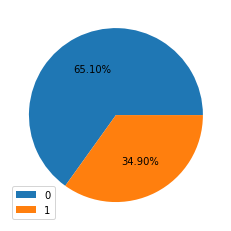

In [199]:
plt.pie(df['Outcome'].value_counts().to_list(), autopct='%.02f%%')
plt.legend(['0', '1'])
plt.show()

### Divisão dos Dados para Treino e Teste

Dado o desbalanceamento dos dados, a divisão dos dados usando o método [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do sklearn, iria inserir uma inconsistência nos dados. Podendo coletar mais amostras de uma população do que de outra. Logo, o método adequado é o [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html).

In [200]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df.Outcome):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

### Análise das Features

#### Pregnancies

Representa o número de vezes que aquela paciente ficou grávida.  
Como podemos analisar abaixo, este valor varia entre 0 e 17.  
Neste gráfico podemos analisar a proporção de pacientes com e sem diabetes, levando em consideração o número de gestações.  
Uma curiosidade é que cerca de 140 pacientes, tiveram apenas 1 filho(a). E aproximadamente 30 delas apresentaram diabetes.

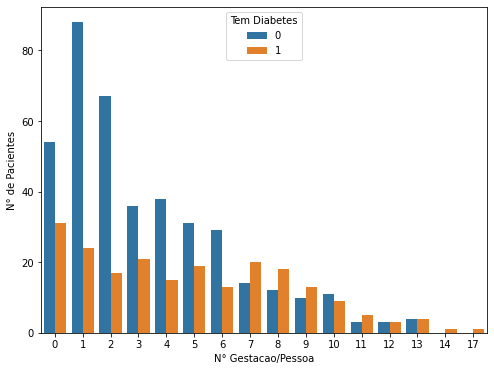

In [201]:
aux = strat_train_set[['Pregnancies','Outcome']].value_counts().sort_index().reset_index()
aux.columns = ['N° Gestacao/Pessoa', 'Tem Diabetes', 'N° de Pacientes']
plt.figure(figsize=(8, 6))
sns.barplot(aux, x='N° Gestacao/Pessoa', y='N° de Pacientes', hue='Tem Diabetes')
plt.show()

#### Glucose

Esta feature representa a "Concentração de glicose plasmática a 2 horas em um teste oral de tolerância à glicose".  
Neste teste é administrado uma quantidade X de glicose no paciente e após 2 horas é medido o valor de glicemia.  
Valores entre 140 e 200 mg/dL é considerado pré-diabetes e acima de 200mg/dL confirma o diagnóstico de diabetes.  
No gráfico abaixo, podemos observar tal feito, o número de casos sem diabetes com valores acima de 150mg/dL diminui considerávelmente.

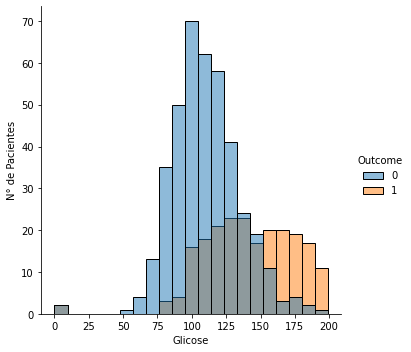

In [202]:
ax = sns.displot(strat_train_set, x="Glucose", hue='Outcome')
plt.xlabel("Glicose")
plt.ylabel('N° de Pacientes')
plt.show()

#### BloodPressure

Pressão arterial diastólica (mmHg)

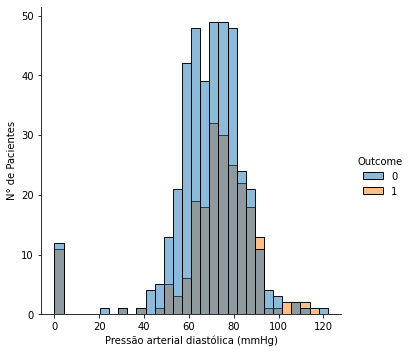

In [203]:
sns.displot(strat_train_set, x="BloodPressure", hue='Outcome')
plt.xlabel("Pressão arterial diastólica (mmHg)")
plt.ylabel('N° de Pacientes')
plt.show()

#### SkinThickness

Espessura da dobra cutânea do tríceps (mm)

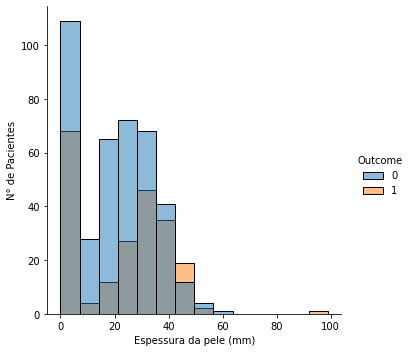

In [204]:
sns.displot(strat_train_set, x="SkinThickness", hue='Outcome')
plt.xlabel("Espessura da pele (mm)")
plt.ylabel('N° de Pacientes')
plt.show()

#### Insulin

Representa a "Insulina sérica de 2 horas (mu U/ml)".

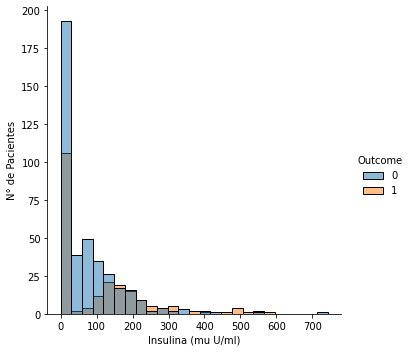

In [205]:
sns.displot(strat_train_set, x="Insulin", hue='Outcome')
plt.xlabel("Insulina (mu U/ml)")
plt.ylabel('N° de Pacientes')
plt.show()

#### BMI

Índice de massa corporal (peso em kg/(altura em m)^2)

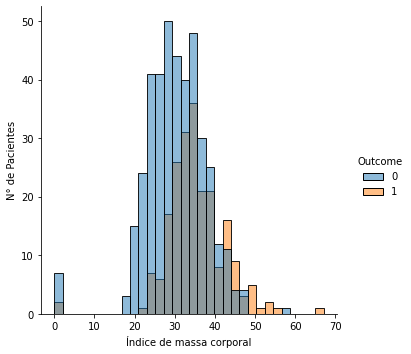

In [206]:
sns.displot(strat_train_set, x="BMI", hue='Outcome')
plt.xlabel("Índice de massa corporal")
plt.ylabel('N° de Pacientes')
plt.show()

#### DiabetesPedigreeFunction

Função hereditária do diabetes

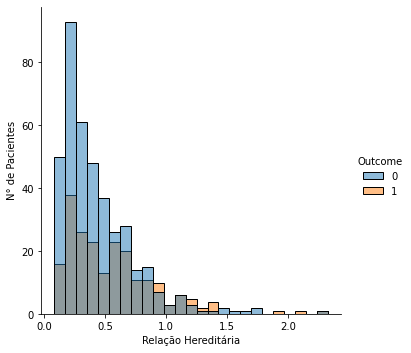

In [207]:
sns.displot(strat_train_set, x="DiabetesPedigreeFunction", hue='Outcome')
plt.xlabel("Relação Hereditária")
plt.ylabel('N° de Pacientes')
plt.show()

#### Age

Idade dos pacientes.

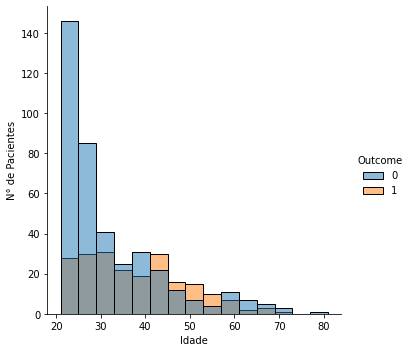

In [208]:
sns.displot(strat_train_set, x="Age", hue='Outcome')
plt.xlabel("Idade")
plt.ylabel('N° de Pacientes')
plt.show()

### Matriz de Correlação

In [209]:
pacientes = strat_train_set.copy()

Matriz de correlação das variáveis:
AxesSubplot(0.125,0.125;0.62x0.755)


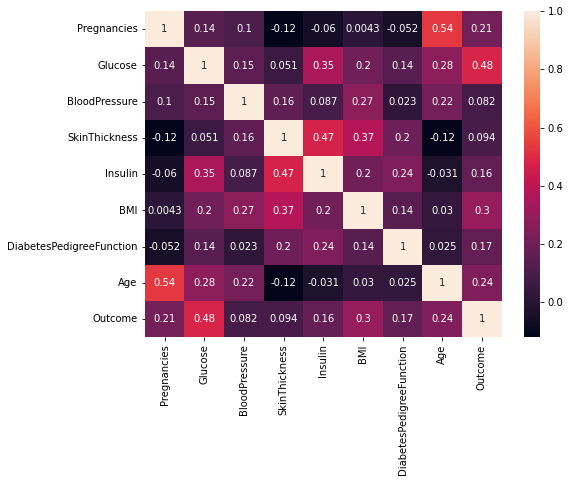

In [210]:
plt.figure(figsize=(8, 6))
print(f"Matriz de correlação das variáveis:\n{sns.heatmap(pacientes.corr(), annot=True)}")
plt.show()

### Custom Transformers 

Em analise da matrix de correlação, foi possível detectar que as features BloodPressure e SkinThickness apresentavam pouca correlação com a variável target(Outcome). Logo fizemos algumas manipulações e podemos observar que a correlação aumentou.

In [211]:
X = strat_train_set.drop('Outcome', axis=1)
y = strat_train_set.Outcome.copy()

In [212]:
from sklearn.base import BaseEstimator, TransformerMixin

BloodPressure_ix, SkinThickness_ix = 2, 3
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, new_BloodPressure = True, new_SkinThickness = True): # no *args or **kargs
        self.new_BloodPressure = new_BloodPressure
        self.new_SkinThickness = new_SkinThickness

    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X, y=None):
        new_BloodPressure = X[:, BloodPressure_ix] ** 2
        new_SkinThickness = X[:, SkinThickness_ix] ** 2
        if self.new_BloodPressure and self.new_SkinThickness:
            X = np.delete(X, [BloodPressure_ix, SkinThickness_ix], 1)
            return np.c_[X, new_BloodPressure, new_SkinThickness]
        elif self.new_SkinThickness:
            X = np.delete(X, SkinThickness_ix, 1)
            return np.c_[X, new_SkinThickness]
        elif self.new_BloodPressure:
            X = np.delete(X, BloodPressure_ix, 1)
            return np.c_[X, new_BloodPressure]
        else:
            return np.c_[X]

attr_adder = CombinedAttributesAdder()
pacientes_extra_attribs = attr_adder.transform(X.values)

In [213]:
pacientes_extra_attribs = np.c_[pacientes_extra_attribs, y]

Matriz de correlação das variáveis:
AxesSubplot(0.125,0.125;0.62x0.755)


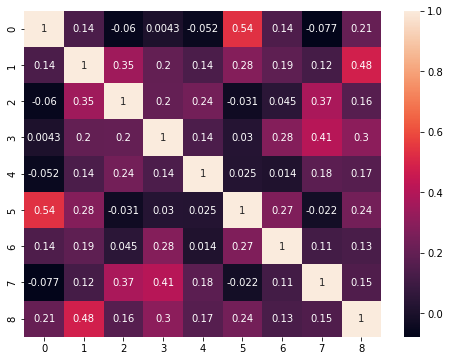

In [214]:
plt.figure(figsize=(8, 6))
print(f"Matriz de correlação das variáveis:\n{sns.heatmap(pd.DataFrame(pacientes_extra_attribs).corr(), annot=True)}")
plt.show()

### Pipelines

In [231]:

num_pipeline = Pipeline([
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
    ])

pacientes_prepared = num_pipeline.fit_transform(X.values)

### Treinamento

In [232]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(pacientes_prepared, y)

In [233]:
clf.feature_importances_

array([0.10044158, 0.30917422, 0.06618291, 0.15839479, 0.10949978,
       0.13094431, 0.09692701, 0.02843541])

In [234]:
clf.score(X, y)

C:\Users\darla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


0.41368078175895767

### Cross-validation

In [235]:
scores = cross_val_score(clf, pacientes_prepared, y, scoring="f1", cv=10)

In [236]:
scores

array([0.52173913, 0.47368421, 0.56521739, 0.7       , 0.60869565,
       0.47619048, 0.41176471, 0.53333333, 0.57142857, 0.48780488])

In [237]:
scores.mean()

0.5349858349322874

In [238]:
scores.std()

0.07727050570402309

### Tune hyperparameters